<a href="https://colab.research.google.com/github/lubsanovdmitry/mong-ocr-materials/blob/main/Project_Classic_Mongolian_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здесь будем пытаться в распознавание текста на старомонгольской письменности.

# О письменности

Краткая историческая справка такова: в XIII в. Чингис хан позаимствовал у уйгуров их письменность, а те ещё в IX в. --- у согдийцев, а оттуда оно (как и многий прочие) восходит к арамейскому. Записывается сверху-вниз, слева-направо (чтобы писать его вместе с китайскими текстами в те времена). Впрочем, китайский, корейский, японский с тех пор чаще пишутся как обычно, слева-направо, а монгольский так записать трудно (по-хорошему, тогда должно писать его справа-налево).

С 1940-х вышло из употребления в Калмыкии, Бурятии и Монголии, но осталось во Внутренней Монголии.

Из технических особенностей: слова пишутся «связно» даже в печатном варианте, вид «букв» зависит от положения в слове, а иногда --- и от других букв (так что его чаще заучивают как слоговую азбуку). Также, есть очень странные «решения», не очень характерные для монгольских языков, например: не различаются о и у, ө и ү, не всегда --- а и э. На реализацию письменности в Юникод часто ругаются (а существуют ещё и альтернативные кодировки, почти все --- из АРВМ КНР). Предпринимались на протяжении веков попытки исправить ситуацию, но все они, кроме «тодо бэшэг», потерпели неудачу, да это «чистое (ясное) письмо» стало популярным только у ойратов (калмыков).

Ещё надо упомянуть вот что: язык, скрывающийся под письменностью, и современные халхасский монгольский, бурятский и т.д. --- вообще говоря, разные языки. Старомонгольский можно, наверное, сравнить с литературным арабским: на нём пишут (писали), но говорят на диалектах.

Тем не менее, с 1990-х Монголия предпринимает попытки по возрождению письма. Школьники и студенты, в целом, могут читать и писать на нём, но эта письменность практически отстутвует за пределами учебных заведений. С 2025 года Монголия планирует начать уже полномасштабный переход.

# Распознавание

В силу вышеупомянутых причин, наличия огромного числа стилей, распознавание текста --- непростая задача. Необходимо как-то расчленить на символы (а ещё лучше этого напрямую не делать), а ещё и как-то учитывать контекст.

Будем использовать для распознавания метод TrOCR, как достаточно точный и простой в обращении.

Этот метод основан на архитектуре Transformer, и, как обычный, состоит из кодировщика и декодеровщика. В качестве кодировщика подходит любой Vision Transformer (зд. --- ViT `google/vit-base-patch16-224-in21k`) и языковая модель-декодер (BERT). Для второй надо в нашем случае её предобучить, чтобы та заучила слова, языковые конструкции... (получается два в одном). Таким образом, была обучена модель типа RoBERTa (токенайзер --- `ByteLevelBPEncoder`).




In [1]:
!pip install paddlepaddle==3.0.0beta1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00


In [3]:
#@title Инклюды

!pip install "paddleocr>=2.0.1" # Recommend to use version 2.0.1+
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=c5ad7b5122c8d7fd217e5a6b6e6399ece0b3e9ead5158d56fb80516888295c2b
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [76]:
#@title Транслитерация
# 0.17 0.15
from collections import defaultdict
convert = defaultdict(lambda: '?', {
    'ᠠ':'a',
    '‍ᠡ':'e',
    'ᠡ':'e',
    'ᠧ':'ee',
    'ᠢ':'i',
    'ᠣ':'o',
    'ᠥ':'ö',
    'ᠤ':'u',
    'ᠦ':'ü',
    'ᠨ':'n',
    'ᠩ':'ng',
    'ᠪ':'b',
    'ᠫ':'p',
    'ᠬ':'q',
    'ᠭ':'g',
    'ᠮ':'m',
    'ᠯ':'l',
    'ᠰ':'s',
    'ᠱ':'ş',
    'ᡸ':'ş',
    'ᠲ':'t',
    'ᠳ':'d',
    'ᠴ':'ç',
    'ᠵ':'j',
    'ᠶ':'y',
    'ᠷ':'r',
    'ᠸ':'w',
    'ᠹ':'f',
    'ᠺ':'k',
    'ᠻ':'kh',
    'ᠼ':'c',
    'ᠽ':'z',
    'ᠾ':'haa',
    'ᠿ':'zra',
    'ᡀ':'lh',
    'ᡁ':'ž',
    'ᡂ':'ç',
    ' ':' ',
    u'\u202f':'-',
    '᠂':',',
    '᠃':'.',
    u'\u180b':'',
    u'\u180e':'-',
    u'\u180c':'',
    u'\u180d':'',
    u'\u180f':'',
    '᠅':u'\u220e',
    '᠄':':',
})

def translit(text):
  new_text = ''
  for c in text:
    new_text += convert[c]
  return new_text

In [75]:
processor = TrOCRProcessor.from_pretrained("dalubsanov/trocr-mon-mong", revision="224")
model = VisionEncoderDecoderModel.from_pretrained("dalubsanov/trocr-mon-mong", revision="224")

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

In [78]:
def ocr_it(image):
  pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

  generated_ids = model.generate(pixel_values)

  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [11]:
!gdown --fuzzy https://drive.google.com/file/d/1H9O32WyEftXWcGSI4DIT2zptd8zS2ncO/view?usp=drive_link
!gdown --fuzzy https://drive.google.com/file/d/1_6oKcJLjvFOJJ9-BPNHOt4Zn7Ba7hHTt/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1H9O32WyEftXWcGSI4DIT2zptd8zS2ncO
To: /content/lyrics-61724.png
100% 9.33k/9.33k [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_6oKcJLjvFOJJ9-BPNHOt4Zn7Ba7hHTt
To: /content/Pres3.png
100% 52.5k/52.5k [00:00<00:00, 84.3MB/s]


##Единичное распознавание

Распознаем сначала с просто одной строки:


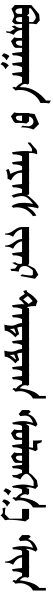

In [98]:
lyr1 = Image.open('/content/lyrics-61724.png').convert('RGB')
display(lyr1)

In [99]:
lyr1_text = ocr_it(lyr1)
tr1 = translit(lyr1_text)
print(lyr1_text, tr1)

ᠪᠣᠷᠣᠭᠠᠨ ᠤ ᠠᠶᠠᠰ ᠢᠶᠠᠷ ᠲᠠᠲᠠᠳᠠᠭ ᠰᠣᠯᠣᠩᠭ᠎ᠠ ᠰᠢᠭ borogan-u ayas-iyar tatadag solongg-a sig


Если верить конвертеру, то на халх. выходит `Борооны аясаар татдаг солонго шиг`, `Словно радуга, нарисованная дождем` (на бур. соот-но `Бороогой аяаар татадаг солонгодо шэнги`)

## Множественное

Воспользуемся для распознавания строчек текста сетью `DBNet`, возьмём её для удобства из пакета `PaddleOCR` (по-хорошему, её бы обучить на текст, но если повернуть текст, то как будто и нормально).

In [67]:
ocr = PaddleOCR(use_angle_cls=True)


[2024/08/07 15:09:47] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

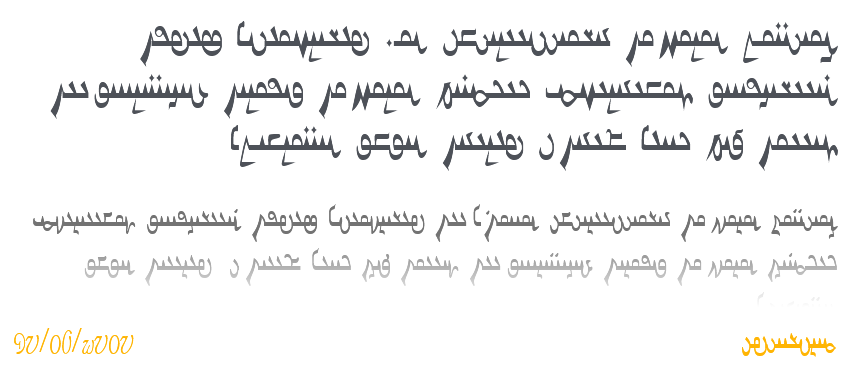

The predicted text box of Pres3.png are follows.
[[[740.0, 331.0], [836.0, 328.0], [836.0, 361.0], [740.0, 363.0]], [[12.0, 324.0], [135.0, 327.0], [134.0, 360.0], [12.0, 358.0]], [[84.0, 248.0], [838.0, 249.0], [838.0, 286.0], [84.0, 285.0]], [[33.0, 206.0], [834.0, 208.0], [834.0, 241.0], [32.0, 239.0]], [[230.0, 125.0], [834.0, 125.0], [834.0, 169.0], [230.0, 169.0]], [[51.0, 75.0], [235.0, 72.0], [235.0, 115.0], [52.0, 117.0]], [[219.0, 77.0], [837.0, 70.0], [837.0, 115.0], [220.0, 121.0]], [[142.0, 17.0], [836.0, 22.0], [836.0, 68.0], [142.0, 62.0]]]


In [113]:
img_path ='Pres3.png'
image = cv2.imread(img_path)
image=cv2.transpose(image)
image=cv2.flip(image,flipCode=1)
cv2_imshow(image)
# 3. Perform inference
result = ocr.ocr(image, rec=False)
print(f"The predicted text box of {img_path} are follows.")
print(result[0])

Развернули (отсюда оно похоже на арабское письмо, что, как я и упомянул ранее, неудивительно), а теперь получаем прямоугольники с текстом:

In [114]:
result = ocr.ocr(image, rec=False)
print(f"The predicted text box of {img_path} are follows.")
print(result[0])

The predicted text box of Pres3.png are follows.
[[[740.0, 331.0], [836.0, 328.0], [836.0, 361.0], [740.0, 363.0]], [[12.0, 324.0], [135.0, 327.0], [134.0, 360.0], [12.0, 358.0]], [[84.0, 248.0], [838.0, 249.0], [838.0, 286.0], [84.0, 285.0]], [[33.0, 206.0], [834.0, 208.0], [834.0, 241.0], [32.0, 239.0]], [[230.0, 125.0], [834.0, 125.0], [834.0, 169.0], [230.0, 169.0]], [[51.0, 75.0], [235.0, 72.0], [235.0, 115.0], [52.0, 117.0]], [[219.0, 77.0], [837.0, 70.0], [837.0, 115.0], [220.0, 121.0]], [[142.0, 17.0], [836.0, 22.0], [836.0, 68.0], [142.0, 62.0]]]


Отобразим и вырежем их:

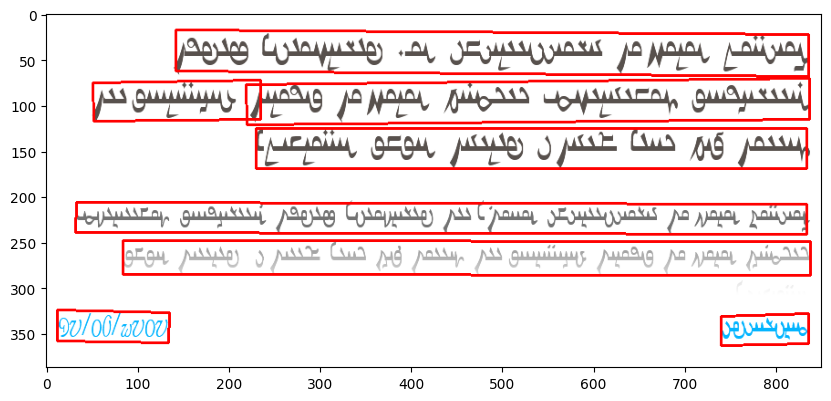

In [115]:
%matplotlib inline
# 4. Visual inspection results
img = image.copy()
for_ocr = []
boxes = [line[0] for line in result]
for box in result[0]:
  box = np.reshape(np.array(box), [-1, 1, 2]).astype(np.int64)
  img = cv2.polylines(np.array(img), [box], True, (255, 0, 0), 2)
  x, y, w, h = cv2.boundingRect(box)
  cropped = image[y:y + h, x:x + w]
  for_ocr.append(cropped)
plt.figure(figsize=(10, 10))
plt.imshow(img)

Собственно, распознаем:

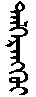

ᠳᠡᠯᠭᠡᠷᠡᠭᠡᠴᠢ delgeregeçi


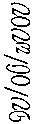

ᠬᠢᠫ᠀ ᠀᠍ ᠀᠀᠍᠅ 4 5 qip? ? ??∎ ? ?


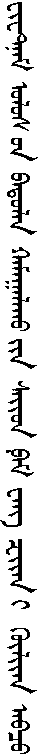

ᠳ᠋ᠧᠲ᠋ᠠᠯᠢ ᠤᠯᠠᠮ ᠪᠣᠳᠣᠨ ᠳᠠᠭᠤᠯᠠᠭᠰᠠᠨ ᠤᠨ ᠰᠢᠨ᠎ᠡ ᠪᠡ ᠳ᠋ᠧᠸᠠᠵᠠᠨ ᠢ ᠬᠦᠯᠢᠶᠡᠨ ᠠᠪᠴᠤ deetali ulam bodon dagulagsan-un sin-e-be deewajan-i qüliyen abçu


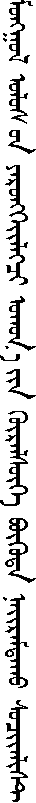

ᠮᠣᠩᠭᠣᠯ ᠤᠨ ᠥᠭᠡᠷ᠎ᠡ ᠦᠨ᠎ᠡ ᠶᠢᠨ ᠪᠦᠵᠢᠭᠯᠡᠪᠡ ᠪᠦᠭᠦᠳᠡ ᠨᠢᠳᠦᠯᠡᠳᠡᠮ ᠰᠥᠢᠳᠡᠮᠡᠭ᠍ᠴᠢ monggol-un öger-e ün-e-yin büjiglebe bügüde nidüledem söidemegçi


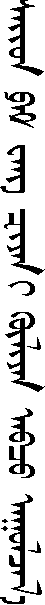

ᠰᠡᠷᠤᠨ ᠀᠋ ᠵᠠᠩᠴᠢᠨ ᠢ ᠬᠦᠯᠢᠶᠡᠨ ᠠᠪᠴᠤ ᠠᠭᠤᠯᠵᠠᠯ᠎ᠠ serun ? jangçin-i qüliyen abçu aguljal-a


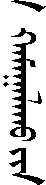

᠍ ᠪᠡᠨᠠᠭᠠᠯᠠᠬᠤ ᠶᠢᠨ -benagalaqu-yin


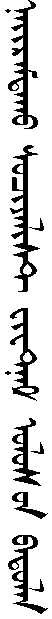

ᠨᠡᠢᠢᠨᠲᠡᠭᠠᠬᠣ ᠰᠥᠵᠢᠢᠯᠡᠰᠢ ᠵᠢᠩᠬᠢᠨᠢ ᠤᠯᠠᠮ ᠤᠨ ᠪᠠᠷᠳᠠᠮ neiintegaqo söjiilesi jingqini ulam-un bardam


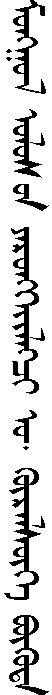

ᠮᠠᠩᠨᠤᠯ ᠮᠦᠰᠲ᠋ᠣᠨ ᠶᠠᠷᠢᠬᠢᠮᠴᠢ ᠢ ᠬᠥᠷᠡᠮᠥᠷᠭᠡ ᠪᠦᠭᠦᠳᠡ mangnul müston yariqimçi i qöremörge bügüde


In [116]:
for i in for_ocr:
  i = gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
  _, i = cv2.threshold(i, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
  i=cv2.transpose(i)
  i=cv2.flip(i,flipCode=0)
  ime = Image.fromarray(np.uint8(255-i)).convert('RGB').rotate(0, expand = 1)
  display(ime)

  generated_text = ocr_it(ime)
  transl = ''
  for c in generated_text:
    char = convert[c]
    transl+=char
  print(generated_text, transl)